[![PracticeProbs](https://d33wubrfki0l68.cloudfront.net/b6800cc830e3fd5a3a4c3d9cfb1137e6a4c15c77/ec467/assets/images/transparent-1.png)](https://www.practiceprobs.com/)

# [Pass Or Fail](https://www.practiceprobs.com/problemsets/pytorch/basic-models/pass-or-fail/)

A class of 100 students takes an exam. At the end of the exam, the students self-report the number of hours they studied 📚 for the exam and the amount of sleep 😴 they got the night before. Here's what the data looks like including the Pass/Fail exam results.

In [1]:
import numpy as np

# random number generator
rng = np.random.default_rng(123)

# data (72 passes / 28 fails)
passes_sleep = rng.normal(loc=8, scale=1, size=72)
passes_study = rng.normal(loc=12, scale=3, size=72)
fails_sleep = rng.normal(loc=6, scale=1.5, size=28)
fails_study = rng.normal(loc=6, scale=2, size=28)

## Plot

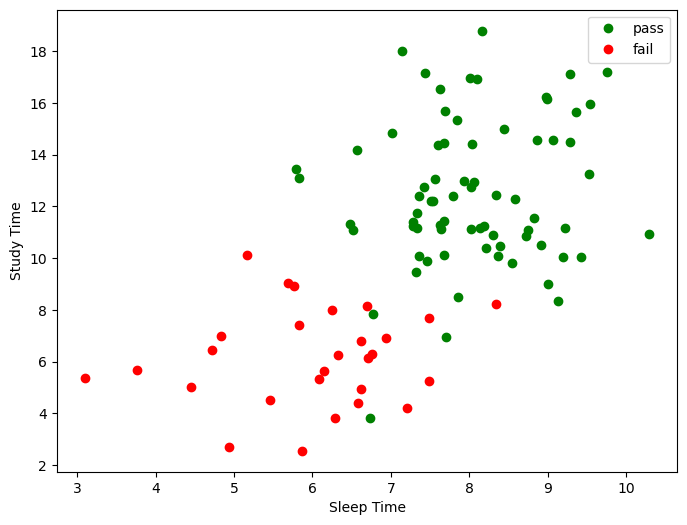

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(passes_sleep, passes_study, linestyle='None', marker='o', color='g', label='pass')
ax.plot(fails_sleep, fails_study, linestyle='None', marker='o', color='r', label='fail')
ax.set_xlabel('Sleep Time')
ax.set_ylabel('Study Time')
ax.legend()

**Design and fit a [logistic regression](https://en.wikipedia.org/wiki/Logistic_function) model to this data**. Be sure to subclass [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).

Here's some starter code.

#### data (72 passes / 28 fails)
- passes_sleep = rng.normal(loc=8, scale=1, size=72)
- passes_study = rng.normal(loc=12, scale=3, size=72)
- fails_sleep = rng.normal(loc=6, scale=1.5, size=28)
- fails_study = rng.normal(loc=6, scale=2, size=28)

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set random seed for reproducibility
torch.manual_seed(0)

class LogisticRegression(nn.Module):
    """
    Logistic Regression model of the form 1/(1 + e^-(w1x1 + w2x2 + ...wnxn + b))
    """
    def __init__(self) -> None:
        super().__init__()
        # in features -> sleep hrs, study hrs
        # out features -> pass/fail
        self.lin = nn.Linear(in_features=2, out_features=1, device=device)

    def forward(self, x):
        return F.sigmoid(self.lin(x))


## Bonus 1

Use your fitted model to make predictions on the following test data.

In [4]:
test_sleep = np.array([
    7.06, 7.19, 7.59, 8.84, 9.66, 9.72, 8.81,
    8.44, 5.66, 9.13, 8.04, 5.31, 7.07, 8.33, 7.83
])
test_study = np.array([
    19.89, 13.36, 12.7, 14.1, 14.19, 12.4, 10.88, 
    13.09, 7.88, 6.35, 4.89, 6.65, 3.67, 5.79, 8.09
])

## Bonus 2

Draw your fitted model's decision boundary onto the plot above.

---

In [5]:
# Your brilliant solution here!

## [See our solution!](https://www.practiceprobs.com/problemsets/pytorch/basic-models/pass-or-fail/solution/)